In [1]:
import xarray as xr
import dask
from xmitgcm import open_mdsdataset
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as pcm
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.colors as col
import cmocean.cm as cm
from colorspace.colorlib import HCL
from colorspace import diverging_hcl, sequential_hcl
from matplotlib import rc, rcParams
# rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
rcParams.update({"text.usetex": True})
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 
rc('axes', labelsize=15)
import cmaps

In [3]:
rootdir = '/export/data1/rmoorman/GRACE-GRACEFO/'
mascon_ds = xr.open_dataset(rootdir+'GRCTellus.JPL.200204_202105.GLO.RL06M.MSCNv02CRI.nc')
landmask_ds = xr.open_dataset(rootdir+'LAND_MASK.CRI.nc')
positions_ds = xr.open_dataset(rootdir+'JPL_MSCNv02_PLACEMENT.nc')

In [4]:
def global_ocean_mascon_map(ds, mascons, vmin, vmax, colormap, landmask,central_longitude=0):
    ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude))
    ax.set_global();
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.75, color='gray', alpha=0.5, linestyle='--') # add lon/lat grid lines
    ocean_mascons = mascons.where(landmask==False)
    mascons = ax.pcolormesh(ds.lon_bounds[:,0], ds.lat_bounds[:,0], ocean_mascons, vmin=vmin, vmax=vmax, cmap=colormap, transform=ccrs.PlateCarree())
    ax.contourf(landmask.lon, landmask.lat,landmask.where(landmask==1),colors=['darkgrey'],transform=ccrs.PlateCarree())
    return mascons

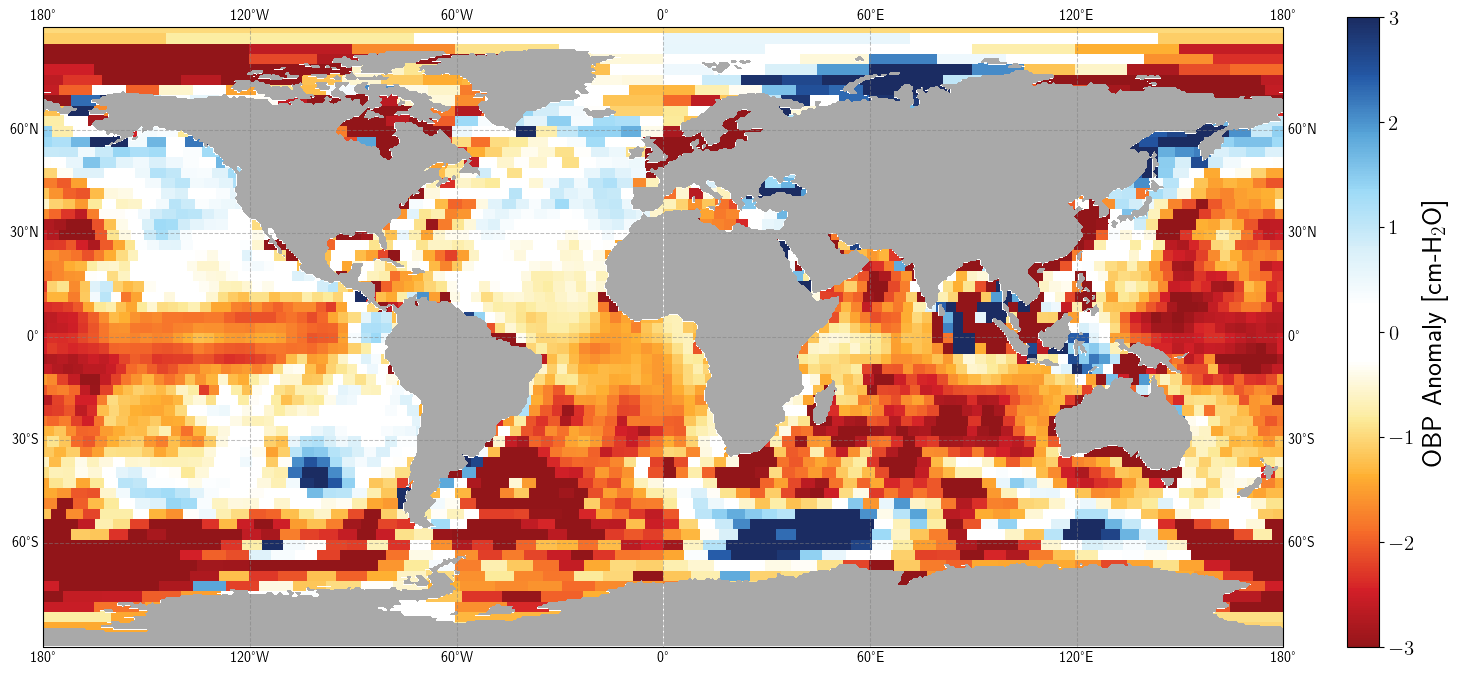

In [5]:
fig = plt.figure(figsize=(16,9))
cs = global_ocean_mascon_map(mascon_ds,mascon_ds.isel(time=0).lwe_thickness, vmin=-3, vmax=3, colormap=cmaps.BlueWhiteOrangeRed_r, landmask=landmask_ds.land_mask)
cax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
cbar=plt.colorbar(cs,cax = cax,orientation='vertical')
cbar.set_label('OBP Anomaly [cm-H$_2$O]', fontsize = 20)
plt.show()

In [6]:
def NA_ocean_mascon_map(ds, mascons, vmin, vmax, colormap, landmask,central_longitude=0, central_latitude=40):
    ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude))
    ax.set_global();
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.75, color='gray', alpha=0.5, linestyle='--') # add lon/lat grid lines
    ax.pcolormesh(landmask.lon, landmask.lat,landmask*0+0.4,cmap=cmaps.MPL_gist_yarg,vmin=0,vmax=1,transform=ccrs.PlateCarree())
    ocean_mascons = mascons.where(landmask==False)
    mascons = ax.pcolormesh(ds.lon_bounds[:,0], ds.lat_bounds[:,0], ocean_mascons, vmin=vmin, vmax=vmax, cmap=colormap, transform=ccrs.PlateCarree())
    ax.set_extent([-100, 30, 0, 90], crs=ccrs.PlateCarree())
    return mascons

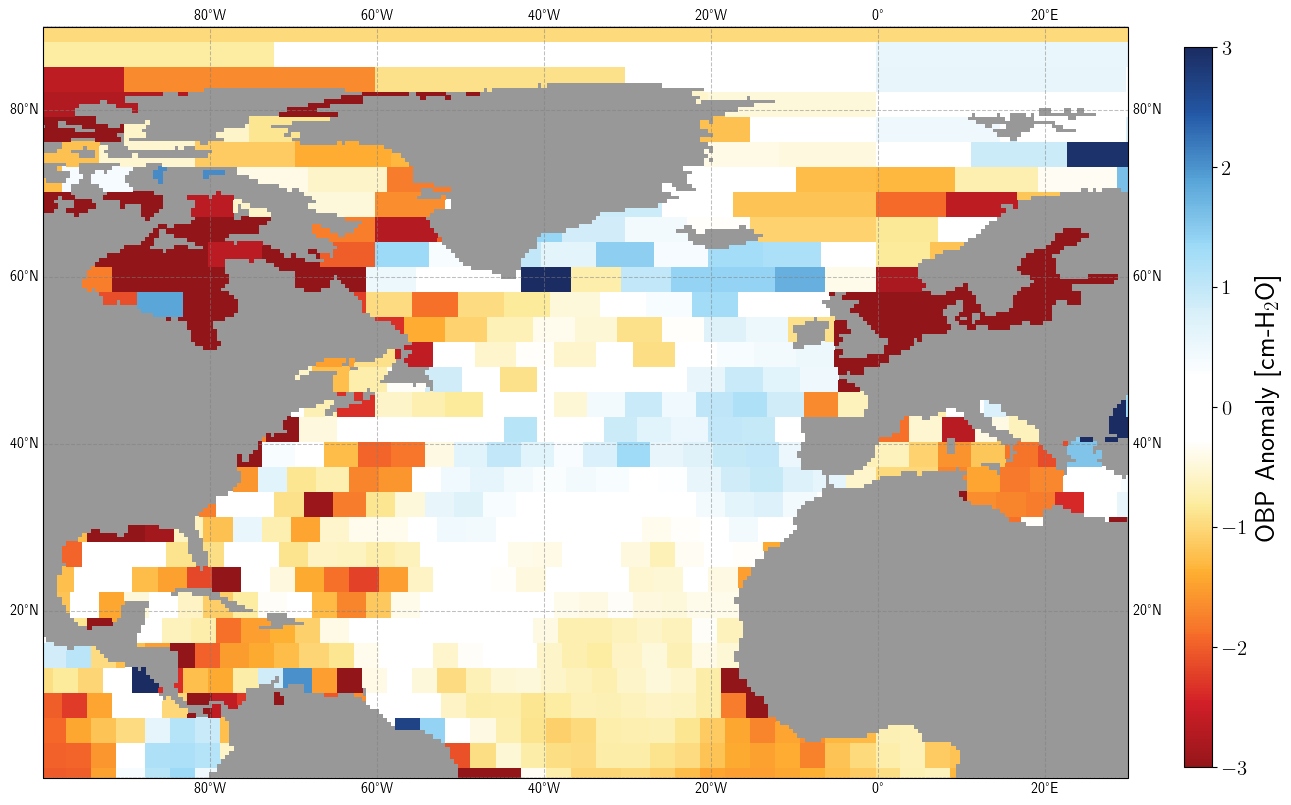

In [7]:
fig = plt.figure(figsize=(14,10))
cs = NA_ocean_mascon_map(mascon_ds,mascon_ds.isel(time=0).lwe_thickness, vmin=-3, vmax=3, colormap=cmaps.BlueWhiteOrangeRed_r, landmask=landmask_ds.land_mask)
cax = fig.add_axes([0.94, 0.13,0.02, 0.72])
cbar=plt.colorbar(cs,cax = cax,orientation='vertical')
cbar.set_label('OBP Anomaly [cm-H$_2$O]', fontsize = 20)

# fig.tight_layout()
plt.show()

In [8]:
np.unique(positions_ds.mascon_rad.values)

array([166.9792])

In [9]:
positions_ds
mascon_lons = xr.DataArray(positions_ds.mascon_lon, coords=[positions_ds.mascon_id], dims=['id'])
mascon_lats = xr.DataArray(positions_ds.mascon_lat, coords=[positions_ds.mascon_id], dims=['id'])
mascon_id = xr.DataArray(positions_ds.mascon_id, coords=[positions_ds.mascon_id], dims=['id'])
mascon_pos = mascon_id.assign_coords(lat=mascon_lats, lon=mascon_lons)

In [10]:
mascon_pos_NA = mascon_pos.where(mascon_pos.lat>=0,drop=True)
mascon_pos_NA1 = mascon_pos_NA.where(mascon_pos_NA.lon<30,drop=True)
mascon_pos_NA2 = mascon_pos_NA.where(mascon_pos_NA.lon>260,drop=True)


In [11]:
len(mascon_pos_NA)

2335

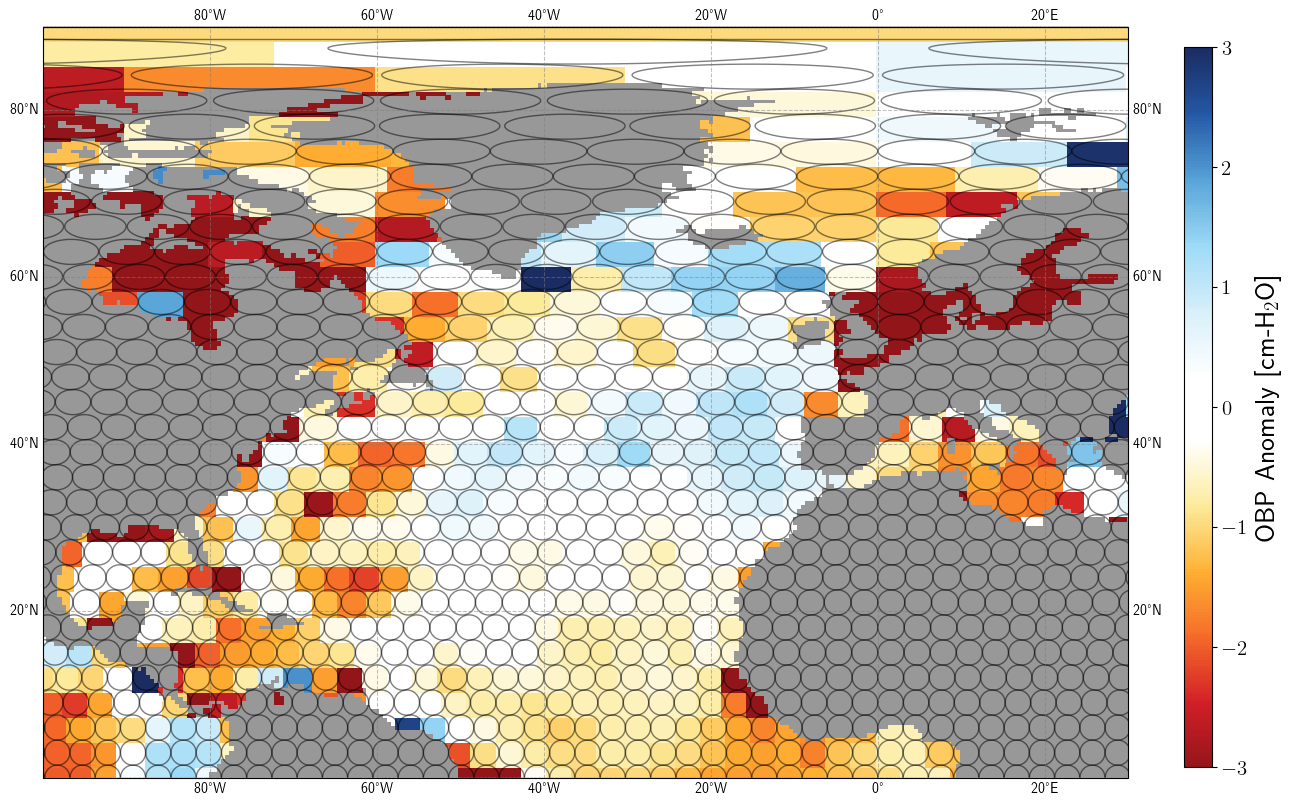

In [12]:
fig = plt.figure(figsize=(14,10))
landmask=landmask_ds.land_mask
colormap=cmaps.BlueWhiteOrangeRed_r
ds = mascon_ds
mascons = mascon_ds.isel(time=0).lwe_thickness
vmin=-3
vmax=3
# cs = NA_ocean_mascon_map(mascon_ds,mascon_ds.isel(time=0).lwe_thickness, vmin=-3, vmax=3, colormap=cmaps.BlueWhiteOrangeRed_r, landmask=landmask_ds.land_mask)
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.set_global();
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.75, color='gray', alpha=0.5, linestyle='--') # add lon/lat grid lines
ax.pcolormesh(landmask.lon, landmask.lat,landmask*0+0.4,cmap=cmaps.MPL_gist_yarg,vmin=0,vmax=1,transform=ccrs.PlateCarree())
ocean_mascons = mascons.where(landmask==False)
mascons = ax.pcolormesh(ds.lon_bounds[:,0], ds.lat_bounds[:,0], ocean_mascons, vmin=vmin, vmax=vmax, cmap=colormap, transform=ccrs.PlateCarree())

#overlay with mascon spherical cap geometry
for i in range(len(mascon_pos_NA)):
    ax.tissot(rad_km=166.9792,lons=mascon_pos_NA.lon.values[i],lats=mascon_pos_NA.lat.values[i], facecolor='none', edgecolor='black', alpha=0.5)

ax.set_extent([-100, 30, 0, 90], crs=ccrs.PlateCarree())

cax = fig.add_axes([0.94, 0.13,0.02, 0.72])
cbar=plt.colorbar(cs,cax = cax,orientation='vertical')
cbar.set_label('OBP Anomaly [cm-H$_2$O]', fontsize = 20)

plt.show()

In [171]:
# want to make an array with some mascon id number assigned to all the cells associated with a single mascon grid
# so it can be used for things like identifying bathymetry values associated with eash grid.
# mascon_id = xr.DataArray(np.zeros((360,720)), coords = [mascon_ds.lat, mascon_ds.lon], dims=['lat','lon'], name='mascon_index')
mascon_id = np.zeros((360,720))
mascon_lat_bounds = np.append(-90,np.diff(np.unique(mascon_pos.lat))/2+np.unique(mascon_pos.lat)[:-1])
mascon_lat_bounds = np.append(mascon_lat_bounds,90)
mascon_lat_center = np.unique(mascon_pos.lat)
longrid,latgrid = np.meshgrid(mascon_ds.lon, mascon_ds.lat)
# this will get looped through, start with most southern to test
# leave out -90 lat region (that will be zero)
count=1
for a in range(1,61):
    lat_center = mascon_lat_center[a]
#     print(lat_center)
    print(mascon_lat_bounds[a],mascon_lat_bounds[a+1])
    i, j = np.where((latgrid>mascon_lat_bounds[a])&(latgrid<=mascon_lat_bounds[a+1]))
    indices_1 = np.stack((i,j)).T
    set1 = set([tuple(x) for x in indices_1])
    mascon_lon_bounds = np.append(0,np.diff(mascon_pos.where(mascon_pos.lat==lat_center, drop=True).lon)/2+mascon_pos.where(mascon_pos.lat==lat_center, drop=True).lon[:-1])
    mascon_lon_bounds = np.append(mascon_lon_bounds,360)
    for b in range(len(mascon_lon_bounds)-1):
        i, j = np.where((longrid>mascon_lon_bounds[b])&(longrid<=mascon_lon_bounds[b+1]))
        indices_2 = np.stack((i,j)).T
        set2 = set([tuple(x) for x in indices_2])
        indices = [x for x in set1 & set2]
#         mascon_id[indices] = count
        for k in range(len(indices)):
            mascon_id[indices[k]] = count
        count += 1
        

-88.5 -85.5
-85.5 -82.5
-82.5 -79.5
-79.5 -76.5
-76.5 -73.5
-73.5 -70.5
-70.5 -67.5
-67.5 -64.5
-64.5 -61.5
-61.5 -58.5
-58.5 -55.5
-55.5 -52.5
-52.5 -49.5
-49.5 -46.5
-46.5 -43.5
-43.5 -40.5
-40.5 -37.5
-37.5 -34.5
-34.5 -31.5
-31.5 -28.5
-28.5 -25.5
-25.5 -22.5
-22.5 -19.5
-19.5 -16.5
-16.5 -13.5
-13.5 -10.5
-10.5 -7.5
-7.5 -4.5
-4.5 -1.5
-1.5 1.5
1.5 4.5
4.5 7.5
7.5 10.5
10.5 13.5
13.5 16.5
16.5 19.5
19.5 22.5
22.5 25.5
25.5 28.5
28.5 31.5
31.5 34.5
34.5 37.5
37.5 40.5
40.5 43.5
43.5 46.5
46.5 49.5
49.5 52.5
52.5 55.5
55.5 58.5
58.5 61.5
61.5 64.5
64.5 67.5
67.5 70.5
70.5 73.5
73.5 76.5
76.5 79.5
79.5 82.5
82.5 85.5
85.5 88.5
88.5 90.0


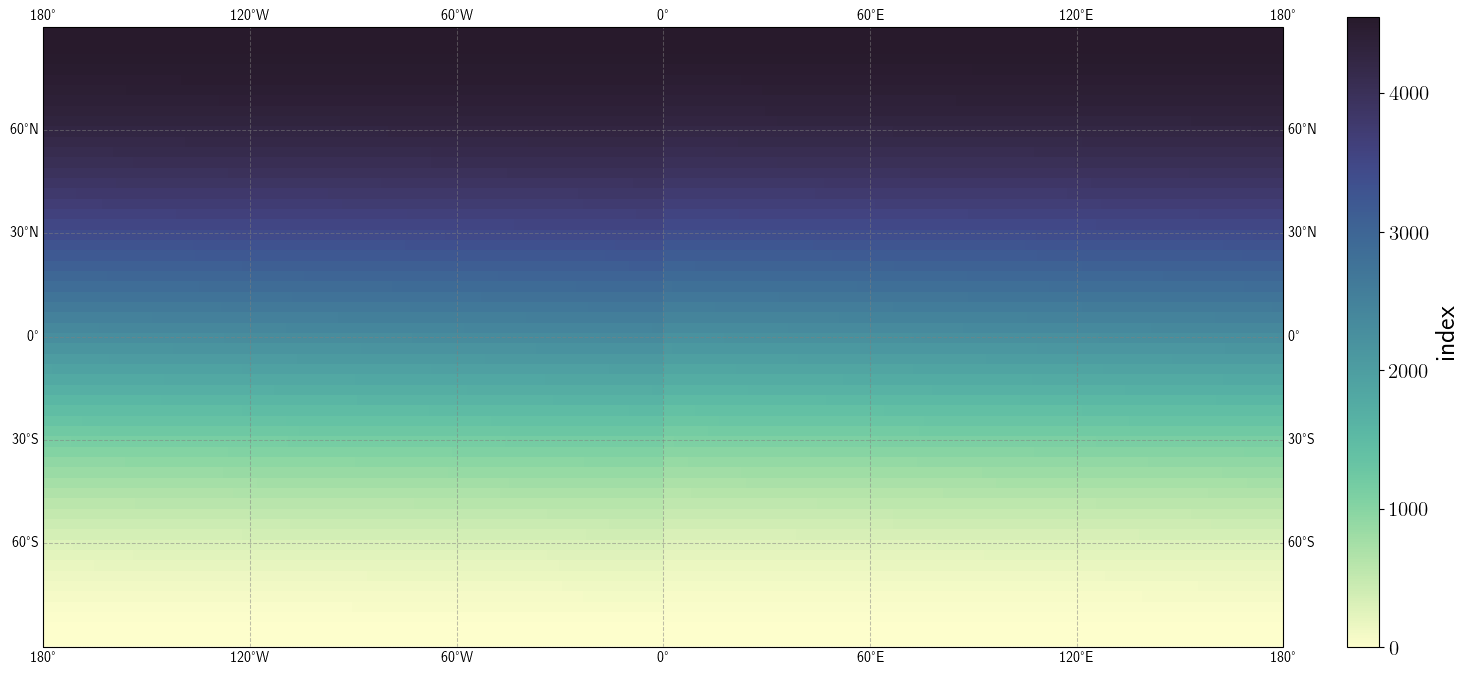

In [172]:
fig = plt.figure(figsize=(16,9))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.75, color='gray', alpha=0.5, linestyle='--') # add lon/lat grid lines
cs = ax.pcolormesh(mascon_ds.lon_bounds[:,0], mascon_ds.lat_bounds[:,0], mascon_id, cmap=cm.deep, transform=ccrs.PlateCarree())

cax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
cbar=plt.colorbar(cs,cax = cax,orientation='vertical')
cbar.set_label('index', fontsize = 20)
plt.show()

In [176]:
mascon_id = xr.DataArray(mascon_id, coords = [mascon_ds.lat, mascon_ds.lon], dims=['lat','lon'], name='mascon_index')

In [177]:
mascon_id

<xarray.DataArray 'mascon_index' (lat: 360, lon: 720)>
array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [4550., 4550., 4550., ..., 4550., 4550., 4550.],
       [4550., 4550., 4550., ..., 4550., 4550., 4550.],
       [4550., 4550., 4550., ..., 4550., 4550., 4550.]])
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8

In [178]:
mascon_ds['mascon_index'] = mascon_id

In [179]:
mascon_ds

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 360, lon: 720, time: 197)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-05-16T1...
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 -4.005 -4.005 -4.005 ... 3.913 3.913
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 -90.0 -89.5 -89.5 ... 89.5 89.5 90.0
    lon_bounds     (lon, bounds) float64 0.0 0.5 0.5 1.0 ... 359.5 359.5 360.0
    time_bounds    (time, bounds) datetime64[ns] 2002-04-04 ... 2021-05-31T23...
    mascon_index   (lat, lon) float64 0.0 0.0 0.0 ... 4.55e+03 4.55e+03 4.55e+03
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2021-07-19T09:07:25Z

In [180]:
mascon_ds.to_netcdf(rootdir+'GRCTellus.JPL.200204_202105.GLO.RL06M.MSCNv02CRI-with-indices.nc')

I'm interested in checking out what the bathymetry gradient across these mascons is. since it wil have some bearing on the physical meaning of GRACE OBP measurements. Attempting this below for using GEBCO bathymetry. Could individually consider the bathymetric gradient in y for bathymetry data averaged in 